<a href="https://www.kaggle.com/code/mdshakilhossain69/fix-match-438?scriptVersionId=256490375" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install ipywidgets notebook jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [42]:
import os, sys, math, time, random, shutil, json
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Set the device to GPU if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
from pathlib import Path
import random
import numpy as np
import torch

# ---- User-editable paths ----
DATA_DIR = Path(r"/kaggle/input/skindisnet-metadata/Preprocessed")
OUTPUT_DIR = Path(r"/kaggle/working")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparameters
TRAIN_FRAC = 0.80
VAL_FRAC = 0.10
TEST_FRAC = 0.10
LABELED_FRACTION = 0.40
IMG_SIZE = 224
BATCH_SIZE_LABELED = 16
BATCH_SIZE_UNLABELED = 32
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
EMA_DECAY = 0.999
CONSISTENCY_WEIGHT_MAX = 0.5
CONSISTENCY_RAMPUP_EPOCHS = 10
CONFIDENCE_THRESHOLD = 0.95
SEEDS = [42, 1337, 2025]

# Set global seed for reproducibility
def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Optional: for stricter determinism (PyTorch 1.8+)
    # torch.use_deterministic_algorithms(True)

set_global_seed(12345)
print('\nFixed global seed for split reproducibility:', 12345)
print('Per-run seeds that will be used:', SEEDS)



Fixed global seed for split reproducibility: 12345
Per-run seeds that will be used: [42, 1337, 2025]


In [6]:
from collections import defaultdict
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np  # if not already imported

# Ensure the data path exists
assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR.resolve()}"

# Collect all image paths and labels from folder names (support nested directories)
all_paths = []
all_labels = []
class_to_idx = {}

valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

# Scan dataset directory and assign labels
for p in DATA_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in valid_exts:
        # e.g., .../<superclass>/<class>/<image>.jpg  ->  "superclass_class"
        class_name = f"{p.parent.parent.name}_{p.parent.name}"
        if class_name not in class_to_idx:
            class_to_idx[class_name] = len(class_to_idx)
        all_paths.append(p)
        all_labels.append(class_to_idx[class_name])

all_paths = np.array(all_paths, dtype=object)   # store Path objects safely
all_labels = np.array(all_labels)

num_classes = len(class_to_idx)
print(f"Found {len(all_paths)} images across {num_classes} classes.")

# Split dataset into train/val/test
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(1.0 - TRAIN_FRAC), random_state=12345)
train_idx, temp_idx = next(sss1.split(all_paths, all_labels))

train_paths_all, train_labels_all = all_paths[train_idx], all_labels[train_idx]
temp_paths, temp_labels = all_paths[temp_idx], all_labels[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=12345)
val_idx_rel, test_idx_rel = next(sss2.split(temp_paths, temp_labels))
val_paths, val_labels = temp_paths[val_idx_rel], temp_labels[val_idx_rel]
test_paths, test_labels = temp_paths[test_idx_rel], temp_labels[test_idx_rel]

# Split labeled/unlabeled data
sss3 = StratifiedShuffleSplit(n_splits=1, test_size=1 - LABELED_FRACTION, random_state=12345)
lab_idx, unlab_idx = next(sss3.split(train_paths_all, train_labels_all))

lab_paths, lab_labels = train_paths_all[lab_idx], train_labels_all[lab_idx]
unlab_paths = train_paths_all[unlab_idx]

# Save split manifests for transparency/debugging
splits_dir = OUTPUT_DIR / 'splits'
splits_dir.mkdir(parents=True, exist_ok=True)

pd.DataFrame({'path': train_paths_all.astype(str), 'label': train_labels_all}).to_csv(splits_dir / 'train_all.csv', index=False)
pd.DataFrame({'path': val_paths.astype(str), 'label': val_labels}).to_csv(splits_dir / 'val.csv', index=False)
pd.DataFrame({'path': test_paths.astype(str), 'label': test_labels}).to_csv(splits_dir / 'test.csv', index=False)
pd.DataFrame({'path': lab_paths.astype(str), 'label': lab_labels}).to_csv(splits_dir / 'train_labeled.csv', index=False)
pd.DataFrame({'path': unlab_paths.astype(str)}).to_csv(splits_dir / 'train_unlabeled.csv', index=False)

print(f"Split CSVs saved under: {splits_dir.resolve()}")


Found 1710 images across 6 classes.
Split CSVs saved under: /kaggle/working/splits


In [7]:
import json

# Save splits as JSON
splits_dict = {
    "train_all": {"path": train_paths_all.astype(str).tolist(), "label": train_labels_all.tolist()},
    "val": {"path": val_paths.astype(str).tolist(), "label": val_labels.tolist()},
    "test": {"path": test_paths.astype(str).tolist(), "label": test_labels.tolist()},
    "train_labeled": {"path": lab_paths.astype(str).tolist(), "label": lab_labels.tolist()},
    "train_unlabeled": {"path": unlab_paths.astype(str).tolist()}
}

# Save to JSON file
splits_json_path = splits_dir / 'splits.json'
with open(splits_json_path, 'w') as json_file:
    json.dump(splits_dict, json_file, indent=4)

print(f"Split JSON saved under: {splits_json_path.resolve()}")


Split JSON saved under: /kaggle/working/splits/splits.json


In [8]:
import torch
import torch.nn as nn
import timm  # Assuming you're using timm library for model creation
import copy  # This is the missing import

def create_student_teacher(num_classes, use_pretrained=True, device='cpu'):
    """
    Creates a student-teacher model setup for FixMatch.
    The student model is the model that will be trained.
    The teacher model is a copy of the student model with frozen parameters.
    """
    # Student model (main model that will be trained)
    try:
        # Load pre-trained weights if needed
        student = timm.create_model('mobilenetv3_large_100', pretrained=use_pretrained, num_classes=num_classes)
    except Exception as e:
        print(f"Error loading pre-trained model: {e}")
        student = timm.create_model('mobilenetv3_large_100', pretrained=False, num_classes=num_classes)

    # Teacher model (copy of the student, frozen for pseudo-label generation)
    teacher = copy.deepcopy(student)  # Use copy.deepcopy() after importing copy
    for param in teacher.parameters():
        param.requires_grad = False  # Freeze teacher model parameters
    teacher.eval()

    student.to(device)
    teacher.to(device)
    return student, teacher

In [10]:
# Augmentation pipelines for FixMatch

import torch
from torchvision import transforms

# Handle interpolation enum across torchvision/PIL versions
try:
    from torchvision.transforms import InterpolationMode
    BILINEAR = InterpolationMode.BILINEAR
except Exception:
    from PIL import Image
    BILINEAR = Image.BILINEAR

# Weak and strong augmentation pipelines
weak_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.03, 0.03), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.04),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.05, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.03, 0.03), scale=(0.95, 1.05)),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.3, interpolation=BILINEAR),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.02 * torch.randn_like(x)),  # additive Gaussian noise
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.15, scale=(0.02, 0.1), ratio=(0.3, 3.0), value='random'),
])

# Validation / test transform (minimal distortion)
val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [12]:
from torch.utils.data import Dataset
from PIL import Image

class LabeledDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        img = self.transform(img)
        label = int(self.labels[idx])
        return img, label

class UnlabeledDataset(Dataset):
    def __init__(self, paths, weak_transform, strong_transform):
        self.paths = paths
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        weak_img = self.weak_transform(img)
        strong_img = self.strong_transform(img)
        return weak_img, strong_img


In [14]:
# ===== Datasets + DataLoaders (FixMatch-style) =====

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # be resilient to truncated files

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# --- Safe PIL loader ---
def pil_loader(path):
    # Ensure RGB for consistency with normalization stats
    with Image.open(path) as img:
        return img.convert("RGB")

# --- Datasets ---
class LabeledDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = np.asarray(paths, dtype=object)
        self.labels = np.asarray(labels, dtype=np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = pil_loader(self.paths[idx])
        if self.transform is not None:
            img = self.transform(img)
        label = int(self.labels[idx])
        return img, label

class UnlabeledDataset(Dataset):
    """
    Returns two augmented views for FixMatch: (weak_img, strong_img)
    """
    def __init__(self, paths, weak_transform=None, strong_transform=None):
        self.paths = np.asarray(paths, dtype=object)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = pil_loader(self.paths[idx])
        weak_img = self.weak_transform(img) if self.weak_transform is not None else img
        strong_img = self.strong_transform(img) if self.strong_transform is not None else img
        return weak_img, strong_img

# --- Deterministic DataLoader seeding (optional but recommended) ---
def seed_worker(worker_id):
    # Make RNG deterministic per-worker
    worker_seed = 12345 + worker_id
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)

g = torch.Generator()
g.manual_seed(12345)

# --- Instantiate datasets ---
lab_ds   = LabeledDataset(lab_paths,   lab_labels,   weak_transform)
unlab_ds = UnlabeledDataset(unlab_paths, weak_transform, strong_transform)
val_ds   = LabeledDataset(val_paths,   val_labels,   val_transform)
test_ds  = LabeledDataset(test_paths,  test_labels,  val_transform)

# --- DataLoaders ---
lab_loader = DataLoader(
    lab_ds,
    batch_size=BATCH_SIZE_LABELED,
    shuffle=True,
    num_workers=0,           # set >0 for speed (e.g., 2 or 4) if your env supports it
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker if 0 else None,  # only used when num_workers > 0
    generator=g,
)

unlab_loader = DataLoader(
    unlab_ds,
    batch_size=BATCH_SIZE_UNLABELED,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
    worker_init_fn=seed_worker if 0 else None,
    generator=g,
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print(f"DataLoaders -> labeled bs={BATCH_SIZE_LABELED}, unlabeled bs={BATCH_SIZE_UNLABELED}, val/test bs=64")
print(f"Sizes -> labeled: {len(lab_ds)}, unlabeled: {len(unlab_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")


DataLoaders -> labeled bs=16, unlabeled bs=32, val/test bs=64
Sizes -> labeled: 547, unlabeled: 821, val: 171, test: 171


In [15]:
@torch.no_grad()
def update_ema(student: nn.Module, teacher: nn.Module, decay: float = 0.999):
    for t_param, s_param in zip(teacher.parameters(), student.parameters()):
        t_param.data.mul_(decay).add_(s_param.data, alpha=1.0 - decay)


In [16]:
def freeze_first_fraction(model: nn.Module, fraction: float = 0.25, freeze=True):
    """
    Freezes the first `fraction` of layers (excluding the classifier head) during fine-tuning.
    If `freeze` is True, it freezes the layers. If False, it unfrees them.
    """
    params = []
    for n, p in model.named_parameters():
        if 'classifier' in n:
            continue
        params.append((n, p))

    total = len(params)
    k = max(1, int(total * fraction))  # Number of layers to freeze
    frozen = 0

    for i, (n, p) in enumerate(params):
        if i < k:
            p.requires_grad_(freeze)  # Freeze/unfreeze the layer based on the flag
            frozen += 1 if freeze else 0
        else:
            p.requires_grad_(True)  # Keep the remaining layers unfrozen

    return frozen, total

In [19]:
# ===== Minimal trainer & evaluator for your MobileNetV3 setup =====

import time, copy
import numpy as np
from contextlib import nullcontext
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

def evaluate_on_loader(model, loader):
    """
    Helper for validation: returns (f1_macro, acc, precision_macro, recall_macro)
    """
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

    y_pred = np.concatenate(all_preds) if all_preds else np.array([])
    y_true = np.concatenate(all_labels) if all_labels else np.array([])
    if y_true.size == 0:
        return 0.0, 0.0, 0.0, 0.0

    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    return f1, acc, prec, rec

def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1,
                model_name="model",
                scaler=None,
                max_grad_norm=None):
    """
    Supervised trainer (uses your labeled DataLoader).
    Returns (best_model, best_val_f1_macro).
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_f1 = -1.0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0

        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            cm = torch.cuda.amp.autocast() if device.type == "cuda" else nullcontext()
            with cm:
                outputs = model(images)
                loss = criterion(outputs, labels)

            if scaler is not None:
                scaler.scale(loss).backward()
                if max_grad_norm is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_correct += (outputs.argmax(1) == labels).sum().item()
            running_total += labels.size(0)

        train_loss = running_loss / max(1, running_total)
        train_acc = running_correct / max(1, running_total)

        # Validate (macro F1)
        val_f1, val_acc, _, _ = evaluate_on_loader(model, val_loader)
        if scheduler is not None:
            scheduler.step()

        print(f"Epoch {epoch:02d}/{num_epochs:02d} | "
              f"train_loss={self if False else train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_f1={val_f1:.4f} val_acc={val_acc:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, best_val_f1

def evaluate_model(model, test_loader, model_name, classes):
    """
    Final evaluation on test set.
    Returns: (f1_macro, accuracy, avg_inf_time_ms, precision_macro, recall_macro, f1_per_class_dict)
    """
    model.eval()
    all_preds, all_labels = [], []

    if device.type == "cuda":
        torch.cuda.synchronize()
    start = time.perf_counter()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

    if device.type == "cuda":
        torch.cuda.synchronize()
    end = time.perf_counter()

    y_pred = np.concatenate(all_preds) if all_preds else np.array([])
    y_true = np.concatenate(all_labels) if all_labels else np.array([])
    if y_true.size == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0, {}

    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

    # Per-class F1 (aligned to your `classes` order)
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True, zero_division=0)
    f1_class = {cls: report[cls]['f1-score'] for cls in classes}

    total_images = len(y_true)
    avg_inf_time_ms = ((end - start) / max(1, total_images)) * 1000.0

    return f1_macro, acc, avg_inf_time_ms, prec_macro, rec_macro, f1_class


In [34]:
# ===== MobileNetV3 fine-tune / load checkpoint (Kaggle-ready) =====

import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler
import timm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reconstruct classes and num_classes from your earlier mapping
# (assumes class_to_idx exists from your dataset scan)
if "class_to_idx" not in globals():
    raise RuntimeError("class_to_idx not found. Run the dataset scan cell first.")
classes = [None] * len(class_to_idx)
for name, idx in class_to_idx.items():
    classes[idx] = name
num_classes = len(classes)
print(f"num_classes = {num_classes}")

# Use the labeled loader as the supervised training loader if none provided
if "train_loader" not in globals():
    if "lab_loader" not in globals():
        raise RuntimeError("No train_loader or lab_loader found. Create DataLoaders first.")
    train_loader = lab_loader

if "val_loader" not in globals() or "test_loader" not in globals():
    raise RuntimeError("val_loader and/or test_loader not found. Create them first.")

# Writable checkpoint directory on Kaggle
CHECKPOINT_DIR = Path("/kaggle/input/model/pytorch/default/1")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

def freeze_first_fraction(model: nn.Module, fraction: float = 0.25, head_names=("classifier",)):
    """
    Freeze the first `fraction` of parameter tensors (excluding head modules by name).
    Returns (frozen_count, total_count) over non-head params.
    """
    non_head_params = []
    for n, p in model.named_parameters():
        if any(n.startswith(h) for h in head_names):
            continue
        non_head_params.append(p)

    total = len(non_head_params)
    k = int(total * fraction)
    for p in non_head_params[:k]:
        p.requires_grad = False
    return k, total

def check_saved_model(model_name="MobileNet-V3-Large", checkpoint_dir=CHECKPOINT_DIR):
    checkpoint_path = Path(checkpoint_dir) / f"{model_name}.pt"
    if checkpoint_path.exists():
        print(f"Found checkpoint: {checkpoint_path}")
        # Build the same architecture and load state dict
        model = timm.create_model("mobilenetv3_large_100", pretrained=False, num_classes=num_classes)
        state = torch.load(checkpoint_path, map_location="cpu")
        model.load_state_dict(state, strict=True)
        model = model.to(device)
        return model, True
    else:
        print(f"No checkpoint found at {checkpoint_path}. Will train and then save.")
        return None, False

# Try to load a saved model
model_name = "MobileNet-V3-Large"
model, is_saved = check_saved_model(model_name=model_name, checkpoint_dir=CHECKPOINT_DIR)

if not is_saved:
    print("Loading ImageNet-pretrained backbone for fine-tuning...")
    # timm will configure the classifier to `num_classes` automatically
    model = timm.create_model("mobilenetv3_large_100", pretrained=True, num_classes=num_classes).to(device)

    # (Optional) freeze first 25% of non-head parameters
    frozen_count, total_count = freeze_first_fraction(model, fraction=0.25, head_names=("classifier",))
    print(f"Initially frozen tensors (excluding head): {frozen_count}/{total_count}")

    # Loss / Optim / Scheduler / AMP scaler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    scaler = GradScaler()

    # Count params (in millions)
    num_params_m = sum(p.numel() for p in model.parameters()) / 1e6
    print(f"Model params: {num_params_m:.2f}M")

    # ---- Train ----
    # Assumes you already have `train_model(model, train_loader, val_loader, ...)` defined elsewhere.
    # If not, let me know and I’ll drop in a compact trainer.
    trained_model, best_val_f1 = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        num_epochs=1,                 # adjust as needed
        model_name=model_name,
        scaler=scaler
    )

    # ---- Evaluate ----
    # Assumes `evaluate_model(model, test_loader, model_name, classes)` exists.
    test_f1, accuracy, avg_inf_time, precision, recall, f1_class = evaluate_model(
        trained_model, test_loader, model_name, classes
    )
    print(f"Test F1={test_f1:.4f}, Acc={accuracy:.4f}, Avg Inf Time={avg_inf_time:.4f}ms")

    # ---- Save checkpoint ----
    ckpt_path = CHECKPOINT_DIR / f"{model_name}.pt"
    torch.save(trained_model.state_dict(), ckpt_path)
    print(f"Saved checkpoint to: {ckpt_path}")

    # ---- Store results ----
    if "results" not in globals():
        results = []
    results.append([model_name, round(test_f1, 4), round(num_params_m, 2), round(avg_inf_time, 2)])

else:
    print("Using the loaded checkpoint model for further fine-tuning or evaluation.")


Device: cuda
num_classes = 6
Found checkpoint: /kaggle/input/model/pytorch/default/1/MobileNet-V3-Large.pt
Using the loaded checkpoint model for further fine-tuning or evaluation.


In [35]:
def train_one_epoch_fixmatch(student, teacher, lab_loader, unlab_loader, optimizer, scaler, device, epoch, total_epochs):
    student.train()
    teacher.eval()

    # Calculate consistency weight using sigmoid ramp-up
    ramp_epoch = max(epoch - 3, 0)
    cw = CONSISTENCY_WEIGHT_MAX * sigmoid_rampup(ramp_epoch, CONSISTENCY_RAMPUP_EPOCHS)

    sup_loss_sum = 0.0
    unsup_loss_sum = 0.0
    total_loss_sum = 0.0

    steps = max(len(lab_loader), len(unlab_loader))  # Number of steps in the epoch
    lab_iter = cycle(lab_loader)  # Create an iterator for the labeled data
    unlab_iter = cycle(unlab_loader)  # Create an iterator for the unlabeled data

    # Progress bar for training loop
    pbar = tqdm(range(steps), desc=f"Train Ep {epoch}", leave=False)
    for _ in pbar:
        # Get a batch from labeled and unlabeled data
        (x_lab, y_lab) = next(lab_iter)
        (x_weak, x_strong) = next(unlab_iter)
        
        # Move the data to the appropriate device (GPU/CPU)
        x_lab, y_lab = x_lab.to(device, non_blocking=True), y_lab.to(device, non_blocking=True)
        x_weak, x_strong = x_weak.to(device, non_blocking=True), x_strong.to(device, non_blocking=True)

        # Zero the gradients
        optimizer.zero_grad(set_to_none=True)
        
        # Perform mixed precision training (for better performance)
        with torch.cuda.amp.autocast(enabled=True):
            # Supervised loss for labeled data
            logits_lab = student(x_lab)
            sup_loss = F.cross_entropy(logits_lab, y_lab)

            # Teacher pseudo labels for the unlabeled data (from weak augmentation)
            with torch.no_grad():
                t_logits = teacher(x_weak)
                t_probs = torch.softmax(t_logits, dim=1)
                t_conf, t_labels = torch.max(t_probs, dim=1)
                mask = (t_conf >= CONFIDENCE_THRESHOLD).float()

            # Student's strong view on unlabeled data
            s_logits = student(x_strong)
            unsup_loss_all = F.cross_entropy(s_logits, t_labels, reduction='none')
            if mask.sum() > 0:
                unsup_loss = (unsup_loss_all * mask).sum() / (mask.sum() + 1e-8)
            else:
                unsup_loss = torch.tensor(0.0, device=device)

            # Total loss: supervised loss + consistency loss (from unlabeled data)
            loss = sup_loss + cw * unsup_loss

        # Backpropagation and optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update the teacher model using Exponential Moving Average (EMA)
        update_ema(student, teacher, EMA_DECAY)

        # Accumulate the losses for tracking
        sup_loss_sum += sup_loss.item()
        unsup_loss_sum += unsup_loss.item()
        total_loss_sum += loss.item()

        # Update the progress bar with the current loss values
        pbar.set_postfix({
            'sup': f"{sup_loss_sum/(pbar.n+1):.3f}",
            'unsup': f"{unsup_loss_sum/(pbar.n+1):.3f}",
            'cw': f"{cw:.2f}"
        })

    # Average losses over all steps
    sup_loss_avg = sup_loss_sum / steps
    unsup_loss_avg = unsup_loss_sum / steps
    total_loss_avg = total_loss_sum / steps

    return {
        'train_sup_loss': sup_loss_avg,
        'train_unsup_loss': unsup_loss_avg,
        'train_total_loss': total_loss_avg,
        'consistency_weight': cw,
    }

In [36]:
# ---- Consistency weight ramp-up (Mean Teacher / FixMatch style) ----
import numpy as np

def sigmoid_rampup(current: float, rampup_length: int) -> float:
    """
    Smoothly increases from 0 -> 1 over `rampup_length` steps using
    exp(-5 * (1 - t)^2), where t = clamp(current / rampup_length, 0..1).
    """
    if rampup_length <= 0:
        return 1.0
    current = np.clip(current, 0.0, rampup_length)
    phase = 1.0 - current / rampup_length
    return float(np.exp(-5.0 * phase * phase))

# (Optional) convenience wrapper matching your usage pattern
def get_consistency_weight(epoch: int,
                           start_epoch: int = 3,
                           max_w: float = CONSISTENCY_WEIGHT_MAX,
                           rampup_epochs: int = CONSISTENCY_RAMPUP_EPOCHS) -> float:
    ramp_epoch = max(epoch - start_epoch, 0)
    return max_w * sigmoid_rampup(ramp_epoch, rampup_epochs)


Using device: cuda
----------- Run 1/3 — Seed 42 -----------


Train Ep 1:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 1, Val Acc: 0.3158, Val F1: 0.1400
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 2:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 2, Val Acc: 0.2047, Val F1: 0.1300


Train Ep 3:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 3, Val Acc: 0.2749, Val F1: 0.1587


Train Ep 4:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 4, Val Acc: 0.2339, Val F1: 0.1384


Train Ep 5:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 5, Val Acc: 0.3099, Val F1: 0.1876


Train Ep 6:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 6, Val Acc: 0.2456, Val F1: 0.1644


Train Ep 7:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 7, Val Acc: 0.3158, Val F1: 0.1897


Train Ep 8:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 8, Val Acc: 0.2924, Val F1: 0.1649


Train Ep 9:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 9, Val Acc: 0.2924, Val F1: 0.2047


Train Ep 10:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 10, Val Acc: 0.2456, Val F1: 0.1662


Train Ep 11:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 11, Val Acc: 0.2982, Val F1: 0.1872


Train Ep 12:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 12, Val Acc: 0.3275, Val F1: 0.2149
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 13:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 13, Val Acc: 0.3041, Val F1: 0.2131


Train Ep 14:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 14, Val Acc: 0.3392, Val F1: 0.2236
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 15:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 15, Val Acc: 0.2749, Val F1: 0.1941


Train Ep 16:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 16, Val Acc: 0.3041, Val F1: 0.1876


Train Ep 17:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 17, Val Acc: 0.3450, Val F1: 0.2398
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 18:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 18, Val Acc: 0.3275, Val F1: 0.2357


Train Ep 19:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 19, Val Acc: 0.3626, Val F1: 0.2053
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 20:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 20, Val Acc: 0.3158, Val F1: 0.2006


Train Ep 21:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 21, Val Acc: 0.3333, Val F1: 0.1939


Train Ep 22:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 22, Val Acc: 0.3450, Val F1: 0.2337


Train Ep 23:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 23, Val Acc: 0.4035, Val F1: 0.2538
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 24:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 24, Val Acc: 0.3216, Val F1: 0.2156


Train Ep 25:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 25, Val Acc: 0.3626, Val F1: 0.2523


Train Ep 26:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 26, Val Acc: 0.3216, Val F1: 0.2280


Train Ep 27:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 27, Val Acc: 0.3567, Val F1: 0.2517


Train Ep 28:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 28, Val Acc: 0.3977, Val F1: 0.2702


Train Ep 29:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 29, Val Acc: 0.3509, Val F1: 0.2418


Train Ep 30:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 30, Val Acc: 0.3509, Val F1: 0.2414


Train Ep 31:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 31, Val Acc: 0.3099, Val F1: 0.2183


Train Ep 32:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 32, Val Acc: 0.3567, Val F1: 0.2442


Train Ep 33:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 33, Val Acc: 0.3450, Val F1: 0.2403


Train Ep 34:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 34, Val Acc: 0.3743, Val F1: 0.2563


Train Ep 35:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 35, Val Acc: 0.3450, Val F1: 0.2414


Train Ep 36:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 36, Val Acc: 0.3450, Val F1: 0.2437


Train Ep 37:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 37, Val Acc: 0.3743, Val F1: 0.2602


Train Ep 38:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 38, Val Acc: 0.3567, Val F1: 0.2537


Train Ep 39:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 39, Val Acc: 0.3450, Val F1: 0.2458


Train Ep 40:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 40, Val Acc: 0.3392, Val F1: 0.2410


Train Ep 41:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 41, Val Acc: 0.3626, Val F1: 0.2549


Train Ep 42:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 42, Val Acc: 0.3450, Val F1: 0.2436


Train Ep 43:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 43, Val Acc: 0.3509, Val F1: 0.2482


Train Ep 44:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 44, Val Acc: 0.3743, Val F1: 0.2644


Train Ep 45:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 45, Val Acc: 0.3684, Val F1: 0.2579


Train Ep 46:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 46, Val Acc: 0.3509, Val F1: 0.2490


Train Ep 47:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 47, Val Acc: 0.3333, Val F1: 0.2372


Train Ep 48:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 48, Val Acc: 0.3333, Val F1: 0.2369


Train Ep 49:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 49, Val Acc: 0.3392, Val F1: 0.2408


Train Ep 50:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 50, Val Acc: 0.3275, Val F1: 0.2345
Extending training to 75 epochs (test mode).


Train Ep 51:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 51, Val Acc: 0.3392, Val F1: 0.2426


Train Ep 52:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 52, Val Acc: 0.3158, Val F1: 0.2261


Train Ep 53:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 53, Val Acc: 0.3216, Val F1: 0.2292


Train Ep 54:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 54, Val Acc: 0.3275, Val F1: 0.2325


Train Ep 55:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 55, Val Acc: 0.3099, Val F1: 0.2212


Train Ep 56:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 56, Val Acc: 0.3392, Val F1: 0.2420


Train Ep 57:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 57, Val Acc: 0.3158, Val F1: 0.2258


Train Ep 58:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 58, Val Acc: 0.3275, Val F1: 0.2346


Train Ep 59:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 59, Val Acc: 0.3450, Val F1: 0.2454


Train Ep 60:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 60, Val Acc: 0.3216, Val F1: 0.2301


Train Ep 61:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 61, Val Acc: 0.3275, Val F1: 0.2349


Train Ep 62:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 62, Val Acc: 0.3158, Val F1: 0.2244


Train Ep 63:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 63, Val Acc: 0.3216, Val F1: 0.2302


Train Ep 64:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 64, Val Acc: 0.3275, Val F1: 0.2342


Train Ep 65:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 65, Val Acc: 0.3275, Val F1: 0.2344


Train Ep 66:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 66, Val Acc: 0.3450, Val F1: 0.2468


Train Ep 67:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 67, Val Acc: 0.3041, Val F1: 0.2183


Train Ep 68:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 68, Val Acc: 0.3158, Val F1: 0.2251


Train Ep 69:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 69, Val Acc: 0.3099, Val F1: 0.2212


Train Ep 70:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 70, Val Acc: 0.3099, Val F1: 0.2222


Train Ep 71:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 71, Val Acc: 0.3158, Val F1: 0.2256


Train Ep 72:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 72, Val Acc: 0.3216, Val F1: 0.2309


Train Ep 73:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 73, Val Acc: 0.3392, Val F1: 0.2420


Train Ep 74:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 74, Val Acc: 0.3041, Val F1: 0.2179


Train Ep 75:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 75, Val Acc: 0.3099, Val F1: 0.2218
----------- Run 2/3 — Seed 1337 -----------


Train Ep 1:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 1, Val Acc: 0.2690, Val F1: 0.1436
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 2:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 2, Val Acc: 0.2690, Val F1: 0.1378


Train Ep 3:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 3, Val Acc: 0.2632, Val F1: 0.1714


Train Ep 4:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 4, Val Acc: 0.2515, Val F1: 0.1583


Train Ep 5:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 5, Val Acc: 0.2398, Val F1: 0.1610


Train Ep 6:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 6, Val Acc: 0.2690, Val F1: 0.1258


Train Ep 7:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 7, Val Acc: 0.3918, Val F1: 0.2336
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 8:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 8, Val Acc: 0.2982, Val F1: 0.2120


Train Ep 9:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 9, Val Acc: 0.2398, Val F1: 0.1470


Train Ep 10:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 10, Val Acc: 0.2281, Val F1: 0.0982


Train Ep 11:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 11, Val Acc: 0.2807, Val F1: 0.1892


Train Ep 12:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 12, Val Acc: 0.2924, Val F1: 0.2000


Train Ep 13:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 13, Val Acc: 0.3450, Val F1: 0.2182


Train Ep 14:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 14, Val Acc: 0.2632, Val F1: 0.1681


Train Ep 15:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 15, Val Acc: 0.3041, Val F1: 0.2058


Train Ep 16:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 16, Val Acc: 0.2807, Val F1: 0.1809


Train Ep 17:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 17, Val Acc: 0.2982, Val F1: 0.2077


Train Ep 18:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 18, Val Acc: 0.2982, Val F1: 0.1933


Train Ep 19:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 19, Val Acc: 0.3041, Val F1: 0.2106


Train Ep 20:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 20, Val Acc: 0.2865, Val F1: 0.1992


Train Ep 21:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 21, Val Acc: 0.2924, Val F1: 0.2037


Train Ep 22:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 22, Val Acc: 0.2807, Val F1: 0.1852


Train Ep 23:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 23, Val Acc: 0.3099, Val F1: 0.2072


Train Ep 24:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 24, Val Acc: 0.2982, Val F1: 0.2051


Train Ep 25:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 25, Val Acc: 0.3392, Val F1: 0.2296


Train Ep 26:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 26, Val Acc: 0.3216, Val F1: 0.2163


Train Ep 27:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 27, Val Acc: 0.3392, Val F1: 0.2308


Train Ep 28:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 28, Val Acc: 0.3509, Val F1: 0.2393


Train Ep 29:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 29, Val Acc: 0.3275, Val F1: 0.2188


Train Ep 30:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 30, Val Acc: 0.2865, Val F1: 0.1956


Train Ep 31:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 31, Val Acc: 0.3450, Val F1: 0.2370


Train Ep 32:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 32, Val Acc: 0.3450, Val F1: 0.2288


Train Ep 33:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 33, Val Acc: 0.3509, Val F1: 0.2377


Train Ep 34:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 34, Val Acc: 0.3509, Val F1: 0.2407


Train Ep 35:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 35, Val Acc: 0.3158, Val F1: 0.2185


Train Ep 36:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 36, Val Acc: 0.3392, Val F1: 0.2349


Train Ep 37:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 37, Val Acc: 0.3216, Val F1: 0.2193


Train Ep 38:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 38, Val Acc: 0.3509, Val F1: 0.2427


Train Ep 39:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 39, Val Acc: 0.3392, Val F1: 0.2368


Train Ep 40:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 40, Val Acc: 0.3392, Val F1: 0.2279


Train Ep 41:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 41, Val Acc: 0.2982, Val F1: 0.2025


Train Ep 42:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 42, Val Acc: 0.3392, Val F1: 0.2293


Train Ep 43:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 43, Val Acc: 0.3333, Val F1: 0.2303


Train Ep 44:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 44, Val Acc: 0.3333, Val F1: 0.2246


Train Ep 45:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 45, Val Acc: 0.3158, Val F1: 0.2128


Train Ep 46:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 46, Val Acc: 0.3743, Val F1: 0.2512


Train Ep 47:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 47, Val Acc: 0.3216, Val F1: 0.2201


Train Ep 48:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 48, Val Acc: 0.3567, Val F1: 0.2461


Train Ep 49:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 49, Val Acc: 0.3450, Val F1: 0.2347


Train Ep 50:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 50, Val Acc: 0.3216, Val F1: 0.2187
Extending training to 75 epochs (test mode).


Train Ep 51:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 51, Val Acc: 0.3392, Val F1: 0.2310


Train Ep 52:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 52, Val Acc: 0.3392, Val F1: 0.2316


Train Ep 53:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 53, Val Acc: 0.3392, Val F1: 0.2329


Train Ep 54:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 54, Val Acc: 0.3275, Val F1: 0.2244


Train Ep 55:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 55, Val Acc: 0.3275, Val F1: 0.2228


Train Ep 56:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 56, Val Acc: 0.3450, Val F1: 0.2376


Train Ep 57:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 57, Val Acc: 0.3275, Val F1: 0.2226


Train Ep 58:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 58, Val Acc: 0.3275, Val F1: 0.2274


Train Ep 59:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 59, Val Acc: 0.3509, Val F1: 0.2382


Train Ep 60:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 60, Val Acc: 0.3392, Val F1: 0.2302


Train Ep 61:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 61, Val Acc: 0.3158, Val F1: 0.2175


Train Ep 62:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 62, Val Acc: 0.3567, Val F1: 0.2471


Train Ep 63:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 63, Val Acc: 0.3333, Val F1: 0.2285


Train Ep 64:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 64, Val Acc: 0.3509, Val F1: 0.2381


Train Ep 65:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 65, Val Acc: 0.3216, Val F1: 0.2232


Train Ep 66:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 66, Val Acc: 0.3275, Val F1: 0.2268


Train Ep 67:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 67, Val Acc: 0.3509, Val F1: 0.2370


Train Ep 68:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 68, Val Acc: 0.3333, Val F1: 0.2306


Train Ep 69:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 69, Val Acc: 0.3509, Val F1: 0.2406


Train Ep 70:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 70, Val Acc: 0.3567, Val F1: 0.2448


Train Ep 71:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 71, Val Acc: 0.3509, Val F1: 0.2396


Train Ep 72:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 72, Val Acc: 0.3333, Val F1: 0.2276


Train Ep 73:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 73, Val Acc: 0.3333, Val F1: 0.2249


Train Ep 74:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 74, Val Acc: 0.3392, Val F1: 0.2330


Train Ep 75:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 75, Val Acc: 0.3275, Val F1: 0.2198
----------- Run 3/3 — Seed 2025 -----------


Train Ep 1:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 1, Val Acc: 0.2632, Val F1: 0.1265
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 2:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 2, Val Acc: 0.2982, Val F1: 0.1364
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 3:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 3, Val Acc: 0.3099, Val F1: 0.1910
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 4:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 4, Val Acc: 0.3275, Val F1: 0.1854
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 5:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 5, Val Acc: 0.2924, Val F1: 0.1801


Train Ep 6:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 6, Val Acc: 0.2164, Val F1: 0.1769


Train Ep 7:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 7, Val Acc: 0.2515, Val F1: 0.1717


Train Ep 8:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 8, Val Acc: 0.3041, Val F1: 0.1780


Train Ep 9:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 9, Val Acc: 0.3041, Val F1: 0.1885


Train Ep 10:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 10, Val Acc: 0.2865, Val F1: 0.1831


Train Ep 11:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 11, Val Acc: 0.3275, Val F1: 0.1875


Train Ep 12:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 12, Val Acc: 0.2924, Val F1: 0.1691


Train Ep 13:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 13, Val Acc: 0.3099, Val F1: 0.1661


Train Ep 14:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 14, Val Acc: 0.2456, Val F1: 0.1551


Train Ep 15:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 15, Val Acc: 0.3099, Val F1: 0.1943


Train Ep 16:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 16, Val Acc: 0.2982, Val F1: 0.1842


Train Ep 17:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 17, Val Acc: 0.3041, Val F1: 0.2160


Train Ep 18:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 18, Val Acc: 0.3333, Val F1: 0.2199
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 19:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 19, Val Acc: 0.3567, Val F1: 0.2399
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 20:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 20, Val Acc: 0.3450, Val F1: 0.2297


Train Ep 21:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 21, Val Acc: 0.3158, Val F1: 0.2220


Train Ep 22:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 22, Val Acc: 0.3392, Val F1: 0.2402


Train Ep 23:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 23, Val Acc: 0.3099, Val F1: 0.1852


Train Ep 24:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 24, Val Acc: 0.4152, Val F1: 0.2888
Saved new best to: /kaggle/working/checkpoints/Best_FixMatch_Model.pt


Train Ep 25:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 25, Val Acc: 0.4094, Val F1: 0.2883


Train Ep 26:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 26, Val Acc: 0.3626, Val F1: 0.2511


Train Ep 27:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 27, Val Acc: 0.3333, Val F1: 0.2317


Train Ep 28:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 28, Val Acc: 0.3099, Val F1: 0.2214


Train Ep 29:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 29, Val Acc: 0.3216, Val F1: 0.2242


Train Ep 30:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 30, Val Acc: 0.3801, Val F1: 0.2578


Train Ep 31:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 31, Val Acc: 0.3743, Val F1: 0.2643


Train Ep 32:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 32, Val Acc: 0.3450, Val F1: 0.2452


Train Ep 33:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 33, Val Acc: 0.3626, Val F1: 0.2587


Train Ep 34:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 34, Val Acc: 0.3450, Val F1: 0.2468


Train Ep 35:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 35, Val Acc: 0.3509, Val F1: 0.2510


Train Ep 36:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 36, Val Acc: 0.3509, Val F1: 0.2464


Train Ep 37:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 37, Val Acc: 0.3509, Val F1: 0.2481


Train Ep 38:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 38, Val Acc: 0.3626, Val F1: 0.2551


Train Ep 39:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 39, Val Acc: 0.3509, Val F1: 0.2467


Train Ep 40:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 40, Val Acc: 0.3626, Val F1: 0.2550


Train Ep 41:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 41, Val Acc: 0.3684, Val F1: 0.2578


Train Ep 42:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 42, Val Acc: 0.3684, Val F1: 0.2577


Train Ep 43:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 43, Val Acc: 0.3684, Val F1: 0.2572


Train Ep 44:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 44, Val Acc: 0.3626, Val F1: 0.2588


Train Ep 45:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 45, Val Acc: 0.3509, Val F1: 0.2530


Train Ep 46:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 46, Val Acc: 0.3626, Val F1: 0.2562


Train Ep 47:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 47, Val Acc: 0.3450, Val F1: 0.2469


Train Ep 48:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 48, Val Acc: 0.3567, Val F1: 0.2538


Train Ep 49:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 49, Val Acc: 0.3567, Val F1: 0.2561


Train Ep 50:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 50, Val Acc: 0.3567, Val F1: 0.2493
Extending training to 75 epochs (test mode).


Train Ep 51:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 51, Val Acc: 0.3450, Val F1: 0.2441


Train Ep 52:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 52, Val Acc: 0.3626, Val F1: 0.2582


Train Ep 53:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 53, Val Acc: 0.3567, Val F1: 0.2529


Train Ep 54:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 54, Val Acc: 0.3743, Val F1: 0.2690


Train Ep 55:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 55, Val Acc: 0.3626, Val F1: 0.2598


Train Ep 56:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 56, Val Acc: 0.3684, Val F1: 0.2641


Train Ep 57:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 57, Val Acc: 0.3509, Val F1: 0.2493


Train Ep 58:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 58, Val Acc: 0.3509, Val F1: 0.2492


Train Ep 59:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 59, Val Acc: 0.3509, Val F1: 0.2484


Train Ep 60:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 60, Val Acc: 0.3509, Val F1: 0.2497


Train Ep 61:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 61, Val Acc: 0.3626, Val F1: 0.2606


Train Ep 62:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 62, Val Acc: 0.3509, Val F1: 0.2480


Train Ep 63:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 63, Val Acc: 0.3567, Val F1: 0.2578


Train Ep 64:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 64, Val Acc: 0.3450, Val F1: 0.2438


Train Ep 65:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 65, Val Acc: 0.3509, Val F1: 0.2485


Train Ep 66:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 66, Val Acc: 0.3567, Val F1: 0.2551


Train Ep 67:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 67, Val Acc: 0.3626, Val F1: 0.2547


Train Ep 68:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 68, Val Acc: 0.3684, Val F1: 0.2619


Train Ep 69:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 69, Val Acc: 0.3567, Val F1: 0.2541


Train Ep 70:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 70, Val Acc: 0.3626, Val F1: 0.2591


Train Ep 71:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 71, Val Acc: 0.3684, Val F1: 0.2637


Train Ep 72:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 72, Val Acc: 0.3509, Val F1: 0.2491


Train Ep 73:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 73, Val Acc: 0.3626, Val F1: 0.2606


Train Ep 74:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 74, Val Acc: 0.3567, Val F1: 0.2531


Train Ep 75:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipykernel_36/1778927230.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 75, Val Acc: 0.3509, Val F1: 0.2487
Validation Accuracy - Mean: 0.3292, Std: 0.0087
Validation F1        - Mean: 0.2239, Std: 0.0079
Final model saved to: /kaggle/working/checkpoints/Final_FixMatch_Model.pt


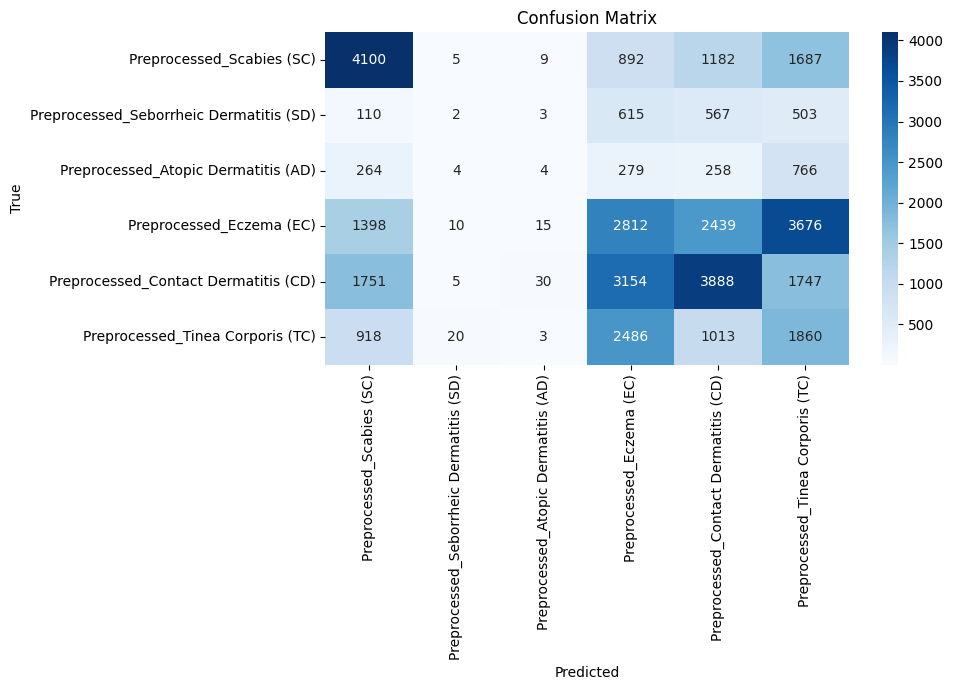

In [38]:
# ===== FixMatch training loop (fully updated cell with evaluate() and working extender) =====

import os
from pathlib import Path
import torch
import torch.nn.functional as F  # used for CE loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_curve
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from itertools import cycle
from tqdm.auto import tqdm

# ---- (safety) ramp-up helpers if not already defined elsewhere ----
if "sigmoid_rampup" not in globals():
    def sigmoid_rampup(current: float, rampup_length: int) -> float:
        if rampup_length <= 0:
            return 1.0
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

# --- toggleable freezing helper ---
def freeze_first_fraction(model, fraction=0.25, freeze=True,
                          head_names=("classifier", "head", "fc"),
                          skip_norms=False):
    """
    Toggle requires_grad for the first `fraction` of NON-head parameters.
    - freeze=True  -> requires_grad=False for first fraction
    - freeze=False -> requires_grad=True  for first fraction
    Returns (affected_count, total_non_head_count).
    """
    non_head = []
    for n, p in model.named_parameters():
        if any(n.startswith(h) or f".{h}." in n for h in head_names):
            continue
        non_head.append((n, p))

    total = len(non_head)
    k = max(0, min(total, int(round(total * fraction))))
    affected = 0
    for n, p in non_head[:k]:
        if skip_norms and ("bn" in n.lower() or "norm" in n.lower()):
            continue
        p.requires_grad = (not freeze)
        affected += 1
    return affected, total

# --- validation helper (returns loss, acc, f1_macro) ---
def evaluate(model, loader, device, desc='Val'):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            logits = model(x)
            loss = F.cross_entropy(logits, y, reduction='sum')  # sum to average later

            total_loss += loss.item()
            preds = logits.argmax(dim=1)

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            y_true.append(y.detach().cpu().numpy())
            y_pred.append(preds.detach().cpu().numpy())

    if total_samples == 0:
        return 0.0, 0.0, 0.0

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    return avg_loss, acc, f1

# Initialize TensorBoard writer (ensure path is a string)
writer = SummaryWriter(log_dir=str(OUTPUT_DIR / "runs"))

# Writable checkpoint path (Kaggle-safe)
CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
best_ckpt_path = CHECKPOINT_DIR / "Best_FixMatch_Model.pt"
final_ckpt_path = CHECKPOINT_DIR / "Final_FixMatch_Model.pt"

# Target val accuracy for optional extension logic
TARGET_VAL_ACC = 0.90  # adjust as you like

# Lists to store results across seeds
all_val_accs, all_val_f1s = [], []
train_losses, val_losses = [], []

# Lists to collect labels for confusion matrix across epochs
all_y_true, all_y_pred = [], []

# Safe function for calculating F1 score and accuracy
def safe_f1_accuracy(y_true, y_pred):
    if len(set(y_true)) == 1:  # all true labels same class
        return 0.0, 0.0
    acc = accuracy_score(y_true, y_pred)
    try:
        f1 = f1_score(y_true, y_pred, average='macro')
    except Exception:
        f1 = 0.0
    return acc, f1

# Confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Only CM
def generate_selected_plots(y_true, y_pred, class_names):
    plot_confusion_matrix(y_true, y_pred, class_names)

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEVICE)

for run_idx, seed in enumerate(SEEDS, start=1):
    print(f"----------- Run {run_idx}/{len(SEEDS)} — Seed {seed} -----------")
    set_global_seed(seed)

    # Models (expects these helpers to exist already)
    student, teacher = create_student_teacher(num_classes=num_classes, use_pretrained=False, device=DEVICE)

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, student.parameters()),
                                  lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scaler = torch.amp.GradScaler(enabled=(DEVICE == 'cuda'))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    best_val_acc = 0.0

    # ---- dynamic epoch loop so we can EXTEND on-the-fly ----
    epoch = 1
    max_epochs = 75        # quick test; increase for real runs
    extended_once = False # prevent infinite extending

    # Per-run val metrics
    val_accs, val_f1s = [], []

    while epoch <= max_epochs:
        # Freeze first 25% of layers for the first 2 epochs; unfreeze later
        if epoch <= 5:
            frozen_count, total_count = freeze_first_fraction(student, fraction=0.25, freeze=True)
        else:
            frozen_count, total_count = freeze_first_fraction(student, fraction=0.25, freeze=False)

        # ---- Train one epoch on FixMatch (expects this helper to exist) ----
        train_stats = train_one_epoch_fixmatch(
            student, teacher, lab_loader, unlab_loader, optimizer, scaler, DEVICE, epoch, max_epochs
        )
        train_losses.append(train_stats['train_total_loss'])

        # ---- Validate ----
        val_loss, val_acc, val_f1 = evaluate(student, val_loader, DEVICE, desc='Val')
        print(f"Epoch {epoch}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        val_losses.append(val_loss)

        # LR scheduler on validation loss (ReduceLROnPlateau)
        scheduler.step(val_loss)

        # TensorBoard logging
        writer.add_scalar('Loss/train', train_stats['train_total_loss'], epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        writer.add_scalar('F1/val', val_f1, epoch)

        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), best_ckpt_path)
            print(f"Saved new best to: {best_ckpt_path}")

        # Track per-epoch val metrics
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        # Collect labels for CM
        with torch.no_grad():
            y_true_epoch, y_pred_epoch = [], []
            for x, y in val_loader:
                x = x.to(DEVICE, non_blocking=True)
                y = y.to(DEVICE, non_blocking=True)
                logits = student(x)
                preds = torch.argmax(logits, dim=1)
                y_true_epoch.append(y.detach().cpu().numpy())
                y_pred_epoch.append(preds.detach().cpu().numpy())
            all_y_true.append(np.concatenate(y_true_epoch))
            all_y_pred.append(np.concatenate(y_pred_epoch))

        # ---- extender: add one more epoch if criteria unmet at epoch 2 ----
        if (not extended_once) and (epoch == 50) and (val_acc < TARGET_VAL_ACC):
            print("Extending training to 75 epochs (test mode).")
            max_epochs =  
            extended_once = True

        epoch += 1  # advance

    # Per-run means
    all_val_accs.append(np.mean(val_accs))
    all_val_f1s.append(np.mean(val_f1s))

# After all runs, aggregate
mean_val_acc = np.mean(all_val_accs)
std_val_acc = np.std(all_val_accs)
mean_val_f1 = np.mean(all_val_f1s)
std_val_f1 = np.std(all_val_f1s)

print(f"Validation Accuracy - Mean: {mean_val_acc:.4f}, Std: {std_val_acc:.4f}")
print(f"Validation F1        - Mean: {mean_val_f1:.4f}, Std: {std_val_f1:.4f}")

# Save final model snapshot
torch.save(student.state_dict(), final_ckpt_path)
print(f"Final model saved to: {final_ckpt_path}")

# Log summary to TensorBoard
writer.add_scalar('Accuracy/mean_val', mean_val_acc)
writer.add_scalar('Accuracy/std_val', std_val_acc)
writer.add_scalar('F1/mean_val', mean_val_f1)
writer.add_scalar('F1/std_val', std_val_f1)
writer.flush()
writer.close()

# Plot confusion matrix with class names in index order
class_names = [name for name, idx in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
generate_selected_plots(
    np.concatenate(all_y_true),
    np.concatenate(all_y_pred),
    class_names=class_names
)


In [9]:
# ===== Standalone eval + save final_results.json =====
from pathlib import Path
import os, json
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Try to import timm and torchvision
import timm
from torchvision import transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# ----- Paths -----
OUTPUT_DIR = Path("/kaggle/working")
SPLITS_DIR = OUTPUT_DIR / "splits"
VAL_CSV = SPLITS_DIR / "val.csv"

BEST_CKPT  = OUTPUT_DIR / "/kaggle/input/model/pytorch/default/1/MobileNet-V3-Large.pt"
FINAL_CKPT = OUTPUT_DIR / "/kaggle/input/model/pytorch/default/1/MobileNet-V3-Large.pt"
ALT_CKPT   = Path("/kaggle/input/model/pytorch/default/1/MobileNet-V3-Large.pt")  # provided path

assert VAL_CSV.exists(), f"Missing {VAL_CSV}. Re-run the split cell to generate it."

# ----- Dataset / Transform -----
def pil_loader(path):
    with Image.open(path) as im:
        return im.convert("RGB")

val_transform = transforms.Compose([
    transforms.Resize(224 + 32),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class CSVImageDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        df = pd.read_csv(csv_path)
        self.paths = df["path"].values
        self.labels = df["label"].values.astype(int)
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = pil_loader(self.paths[idx])
        if self.transform: img = self.transform(img)
        return img, int(self.labels[idx])

val_ds = CSVImageDataset(VAL_CSV, val_transform)
num_classes = int(np.max([0] + val_ds.labels.tolist())) + 1
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# ----- Build model & load checkpoint -----
device = "cuda" if torch.cuda.is_available() else "cpu"
def build_model(nc):
    # Use timm MobileNetV3-Large (same as used earlier)
    return timm.create_model("mobilenetv3_large_100", pretrained=False, num_classes=nc).to(device).eval()

ckpt_path = None
for p in [BEST_CKPT, FINAL_CKPT, ALT_CKPT]:
    if p.exists():
        ckpt_path = p
        break
assert ckpt_path is not None, "No checkpoint found. Train first or place a .pt at one of the expected paths."

model = build_model(num_classes)
state = torch.load(ckpt_path, map_location=device)
missing, unexpected = model.load_state_dict(state, strict=False)
if missing or unexpected:
    print("Warning: non-strict load. Missing keys:", missing[:5], "...", "Unexpected keys:", unexpected[:5])

# ----- Evaluate -----
from sklearn.metrics import f1_score, accuracy_score

model.eval()
ys, ps = [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(1)
        ys.append(y.detach().cpu().numpy())
        ps.append(pred.detach().cpu().numpy())

ys = np.concatenate(ys) if ys else np.array([])
ps = np.concatenate(ps) if ps else np.array([])
assert ys.size > 0, "Validation loader produced no samples."

mean_val_acc = float(accuracy_score(ys, ps))
mean_val_f1  = float(f1_score(ys, ps, average="macro", zero_division=0))
std_val_acc  = 0.0  # single evaluation
std_val_f1   = 0.0

final_results = {
    "mean_val_acc": mean_val_acc,
    "std_val_acc":  std_val_acc,
    "mean_val_f1":  mean_val_f1,
    "std_val_f1":   std_val_f1,
    "evaluated_from": str(ckpt_path),
    "num_classes": num_classes,
    "num_val_samples": int(len(val_ds)),
}

out_path = OUTPUT_DIR / "final_results.json"
with open(out_path, "w") as f:
    json.dump(final_results, f, indent=4)

print(f"Evaluated checkpoint: {ckpt_path}")
print(f"Saved results to: {out_path}")
print(final_results)


NameError: name 'gle' is not defined